# Delivery Route Optimization with A*
This notebook demonstrates an adapted A* algorithm to find a lowest-cost tour starting and ending at a depot while visiting all delivery points. It uses an MST-based admissible heuristic.

In [1]:
import sys
from pathlib import Path
ROOT = Path.cwd().resolve()
if not (ROOT / 'src').exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))
print('Python:', sys.executable)


Python: C:\laragon\www\Faculdade\Jupyter-Project\.venv\Scripts\python.exe


In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from src.route_solver import build_distance_matrix, astar_tsp

%matplotlib inline

## Load data and build distance matrix

In [3]:
data_path = os.path.join('..','data','sample_points.csv') if not os.path.exists(os.path.join('data','sample_points.csv')) else os.path.join('data','sample_points.csv')
df = pd.read_csv(data_path)
labels = df['id'].tolist()
points = df[['x','y']].to_numpy()
depot_idx = 0  # first row is the depot
delivery_indices = list(range(1, len(points)))
dist = build_distance_matrix(points, metric='euclidean')
dist[:5,:5]  # preview

array([[0.        , 3.16227766, 4.12310563, 5.83095189, 6.40312424],
       [3.16227766, 0.        , 3.60555128, 2.82842712, 4.12310563],
       [4.12310563, 3.60555128, 0.        , 4.12310563, 3.16227766],
       [5.83095189, 2.82842712, 4.12310563, 0.        , 2.23606798],
       [6.40312424, 4.12310563, 3.16227766, 2.23606798, 0.        ]])

## Run A* with MST heuristic

In [4]:
path_indices, total_cost = astar_tsp(dist, depot_idx, delivery_indices, heuristic='mst')
route_labels = [labels[i] for i in path_indices]
print('Route:', route_labels)
print('Total cost:', total_cost)

Route: ['D', 'B', 'E', 'C', 'A', 'D']
Total cost: 15.5121560482004


In [5]:
import itertools

def tour_cost(order):
    c = 0.0
    prev = depot_idx
    for j in order:
        c += float(dist[prev, j])
        prev = j
    c += float(dist[prev, depot_idx])
    return c

# Compute best cost and capture all optimal orders (to handle ties)
best_cost = float('inf')
optimal_orders = []
for order in itertools.permutations(delivery_indices):
    c = tour_cost(order)
    if c < best_cost - 1e-12:
        best_cost = c
        optimal_orders = [order]
    elif abs(c - best_cost) <= 1e-9:
        optimal_orders.append(order)

def labels_from_order(order):
    return [labels[depot_idx]] + [labels[i] for i in order] + [labels[depot_idx]]

def cycles_equivalent(t1, t2):
    # both include depot at start and end
    a = t1[1:-1]
    b = t2[1:-1]
    if len(a) != len(b):
        return False
    n = len(a)
    for k in range(n):
        rot = a[k:] + a[:k]
        if rot == b or rot[::-1] == b:
            return True
    return False

astar_labels = [labels[i] for i in path_indices]
found_equiv = any(cycles_equivalent(astar_labels, labels_from_order(o)) for o in optimal_orders)

print("Optimal cost match:", abs(total_cost - best_cost) <= 1e-9)
print("Route equivalent to an optimal:", found_equiv)
print("Best cost:", best_cost)
print("One optimal tour:", labels_from_order(optimal_orders[0]))

Optimal cost match: True
Route equivalent to an optimal: True
Best cost: 15.5121560482004
One optimal tour: ['D', 'A', 'C', 'E', 'B', 'D']


## Visualize

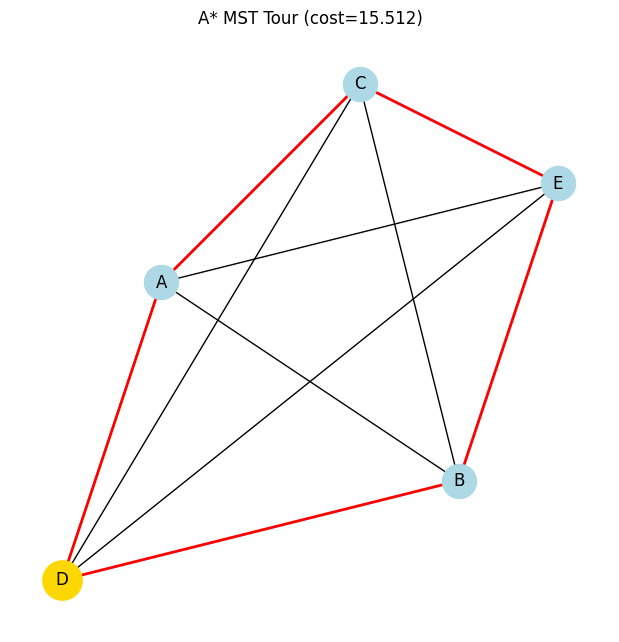

In [6]:
G = nx.Graph()
for i, (x,y) in enumerate(points):
    G.add_node(i, pos=(x,y))
for i in range(len(points)):
    for j in range(i+1, len(points)):
        G.add_edge(i, j, weight=float(dist[i, j]))
pos = {i:(points[i][0], points[i][1]) for i in range(len(points))}
plt.figure(figsize=(6,6))
nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=600)
nx.draw_networkx_nodes(G, pos, nodelist=[depot_idx], node_color='gold', node_size=800)
# label nodes
for i,(x,y) in enumerate(points):
    plt.text(x, y, labels[i], fontsize=12, ha='center', va='center')
# draw tour edges
tour_edges = [(path_indices[k], path_indices[k+1]) for k in range(len(path_indices)-1)]
nx.draw_networkx_edges(G, pos, edgelist=tour_edges, edge_color='red', width=2)
plt.title(f'A* MST Tour (cost={total_cost:.3f})')
plt.show()

In [7]:
import itertools

def tour_cost(order):
    c = 0.0
    prev = depot_idx
    for j in order:
        c += float(dist[prev, j])
        prev = j
    c += float(dist[prev, depot_idx])
    return c

best_order, best_cost = min(
    ((order, tour_cost(order)) for order in itertools.permutations(delivery_indices)),
    key=lambda t: t[1]
)

astar_labels = [labels[i] for i in path_indices]
brute_labels = [labels[depot_idx]] + [labels[i] for i in best_order] + [labels[depot_idx]]

print("A* route:", astar_labels, "cost:", total_cost)
print("Brute-force best:", brute_labels, "cost:", best_cost)
print("Match:", abs(total_cost - best_cost) < 1e-9 and astar_labels == brute_labels)

A* route: ['D', 'B', 'E', 'C', 'A', 'D'] cost: 15.5121560482004
Brute-force best: ['D', 'A', 'C', 'E', 'B', 'D'] cost: 15.5121560482004
Match: False
